In [13]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

In [2]:
# load customer csv file
file_path = 'cymbiotika/customers.csv'
customers = pd.read_csv(file_path)

# check to see if loaded
customers.head(5)

,customer_id,address_id,created_at,external_customer_id
0,163081181,178246210,10/1/24 0:37,7326732156975
1,163082702,178248099,10/1/24 1:27,7326824693807
2,163083184,178248707,10/1/24 1:45,7152438706223
3,163083376,178248933,10/1/24 1:52,7326895472687
4,163083934,178249631,10/1/24 2:13,7326934663215


In [3]:
# load orders csv rile
file_path = 'cymbiotika/orders.csv'
orders = pd.read_csv(file_path)

# check to see if loaded
orders.head(5)

,charge_id,subscription_id,external_product_id,quantity,price,product_type,processed_at,address_id,order_type,line_item_total
0,1191880647,538464600.0,7167834161199,1,50.0,SUBSCRIPTION,10/1/24 0:11,178245265,CHECKOUT,50.0
1,1191880647,538464601.0,4596150632495,2,62.0,SUBSCRIPTION,10/1/24 0:11,178245265,CHECKOUT,124.0
2,1191982681,538468145.0,4696220368943,1,88.0,SUBSCRIPTION,10/1/24 0:34,178246210,CHECKOUT,88.0
3,1191982681,538468152.0,4758525968431,1,60.0,SUBSCRIPTION,10/1/24 0:34,178246210,CHECKOUT,60.0
4,1191982681,538468150.0,6920897101871,1,88.0,SUBSCRIPTION,10/1/24 0:34,178246210,CHECKOUT,88.0


In [4]:
# load subscriptions csv file
file_path = 'cymbiotika/subscriptions.csv'
subscriptions = pd.read_csv(file_path)

# check to see if loaded
subscriptions.head(5)

,created_at,subscription_id,product_title,address_id,status,price,quantity,external_product_id,cancelled_at
0,10/1/24 0:00,538462999,Liposomal Vitamin C,171229036,ACTIVE,34.72,1,4596150632495,NaN
1,10/1/24 0:11,538464600,Liposomal Creatine+,178245265,CANCELLED,32.00,1,7167834161199,10/3/24 12:09
2,10/1/24 0:11,538464601,Liposomal Vitamin C,178245265,CANCELLED,39.68,2,4596150632495,10/3/24 12:09
3,10/1/24 0:37,538468145,Liposomal Glutathione,178246210,CANCELLED,70.40,1,4696220368943,12/2/24 9:59
4,10/1/24 0:37,538468150,Plant Protein,178246210,CANCELLED,70.40,1,6920897101871,12/2/24 9:59


In [5]:
# create a new column in the customers table to show cohort month, which is based on the created_at column
customers['customer_cohort_month'] = pd.to_datetime(customers['created_at']).dt.to_period('M')

# check to see if loaded
customers.head(5)

,customer_id,address_id,created_at,external_customer_id,customer_cohort_month
0,163081181,178246210,10/1/24 0:37,7326732156975,2024-10
1,163082702,178248099,10/1/24 1:27,7326824693807,2024-10
2,163083184,178248707,10/1/24 1:45,7152438706223,2024-10
3,163083376,178248933,10/1/24 1:52,7326895472687,2024-10
4,163083934,178249631,10/1/24 2:13,7326934663215,2024-10


In [6]:
# calculating number of uniques customers in each cohort month
unique_customers = customers.groupby('customer_cohort_month').agg(
    sum_customers=('customer_id', 'nunique')
)

#print result
unique_customers

,sum_customers
customer_cohort_month,
2024-10,3567
2024-11,6656
2024-12,6487


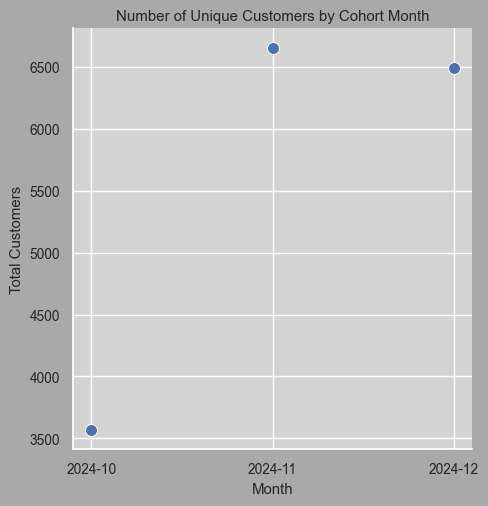

In [7]:
# convert customer_cohort_month to string for scatter plot
unique_customers = unique_customers.reset_index()
unique_customers['customer_cohort_month'] = unique_customers['customer_cohort_month'].astype(str)

# plot scatter plot
sns.set(font_scale=0.9, rc={'axes.facecolor': 'lightgrey', 'figure.facecolor': 'darkgrey'})

unique_customers_plot = sns.relplot(
    data=unique_customers.reset_index(),
    x='customer_cohort_month',
    y='sum_customers',
    s=75,
)

unique_customers_plot.set(
    title='Number of Unique Customers by Cohort Month',
    xlabel='Month',
    ylabel='Total Customers'
)

In [8]:
# calculating average number of total subscriptions per customer by cohort month

# merge customer and subscription tables
customer_subs = pd.merge(customers, subscriptions, on='address_id', how='left')

# calculate count of subs per customer, per month cohort
avg_cohort_subs = customer_subs.groupby(['customer_cohort_month', 'customer_id'])['subscription_id'].count()

# calculate average number of subscriptions per customer for each cohort, rounded to the nearest hundredth
avg_total_subs = avg_cohort_subs.groupby('customer_cohort_month').mean().round(2)

#print result
avg_total_subs

customer_cohort_month
2024-10    2.64
2024-11    2.52
2024-12    2.32
Freq: M, Name: subscription_id, dtype: float64

In [9]:
# convert the index to datetime
avg_total_subs.index = avg_total_subs.index.to_timestamp()

# convert customer_cohort_month to a column
avg_total_subs = avg_total_subs.reset_index()

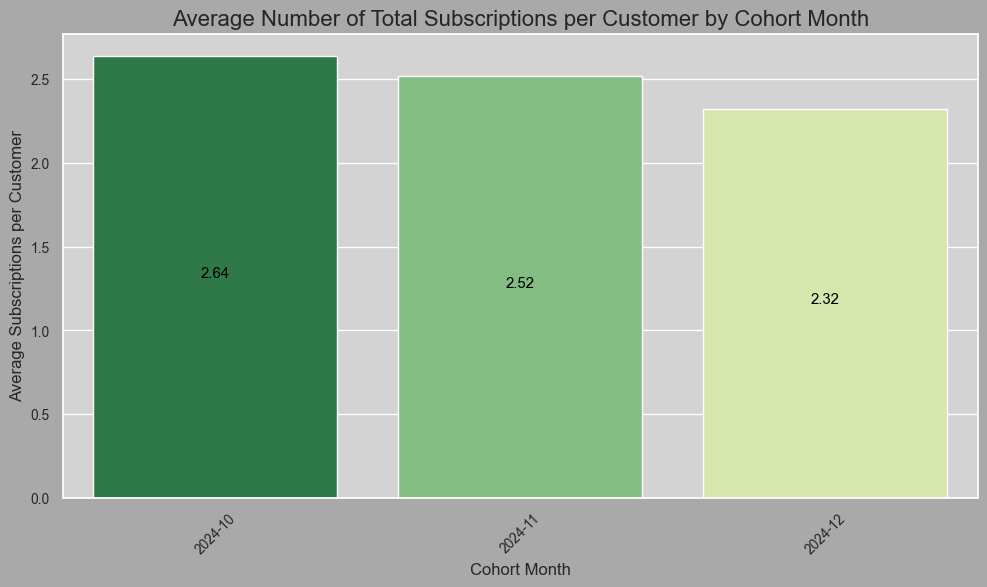

In [10]:
# only show date on 'customer_cohort_month'
avg_total_subs['customer_cohort_month'] = avg_total_subs['customer_cohort_month'].dt.strftime('%Y-%m')

# plot bar graph
plt.figure(figsize=(10, 6))
avg_sub = sns.barplot(
    x='customer_cohort_month',
    y='subscription_id',
    data=avg_total_subs,
    palette='YlGn_r'
)

# format bar graph
plt.xticks(rotation=45)
plt.title('Average Number of Total Subscriptions per Customer by Cohort Month', fontsize=16)
plt.xlabel('Cohort Month', fontsize=12)
plt.ylabel('Average Subscriptions per Customer', fontsize=12)
plt.tight_layout()

# add text annotations
for a in avg_sub.patches:
    height = a.get_height()
    avg_sub.text(
        x=a.get_x() + (a.get_width() / 2),
        y=height / 2,
        s=f'{height:.2f}',
        color='black',
        ha='center'
    )

plt.show()

In [11]:
customer_subs.head(3)

,customer_id,address_id,created_at_x,external_customer_id,customer_cohort_month,created_at_y,subscription_id,product_title,status,price,quantity,external_product_id,cancelled_at
0,163081181,178246210,10/1/24 0:37,7326732156975,2024-10,10/1/24 0:37,538468145.0,Liposomal Glutathione,CANCELLED,70.4,1.0,4.696220e+12,12/2/24 9:59
1,163081181,178246210,10/1/24 0:37,7326732156975,2024-10,10/1/24 0:37,538468150.0,Plant Protein,CANCELLED,70.4,1.0,6.920897e+12,12/2/24 9:59
2,163081181,178246210,10/1/24 0:37,7326732156975,2024-10,10/1/24 0:37,538468152.0,Longevity Mushrooms,CANCELLED,48.0,1.0,4.758526e+12,12/2/24 9:59


In [14]:
# convert date columns to datetime
customers['created_at'] = pd.to_datetime(customers['created_at'])
subscriptions['cancelled_at'] = pd.to_datetime(subscriptions['cancelled_at'])

# merge customers and subscriptions tables
customer_subs = pd.merge(customers, subscriptions, on='address_id', how='left')

# calculate end date
current_date = datetime.now()
customer_subs['end_date'] = customer_subs['cancelled_at'].fillna(current_date)

# calculate duration in days
customer_subs['duration_days'] = (customer_subs['end_date'] - customer_subs['created_at_x']).dt.days

# group by customer cohort month and calculate the average duration
avg_duration = customer_subs.groupby('customer_cohort_month')['duration_days'].mean().round(2)

# reset index
avg_duration = avg_duration.reset_index()

# print result
avg_duration

,customer_cohort_month,duration_days
0,2024-10,65.23
1,2024-11,46.38
2,2024-12,31.48


In [15]:
# calculate AOV by cohort month

# convert 'created_at' and 'processed_at' columns to datetime
customers['created_at'] = pd.to_datetime(customers['created_at'])
orders['processed_at'] = pd.to_datetime(orders['processed_at'])

# add customer cohort month to orders by merging with customers
orders_with_cohort = pd.merge(
    orders, 
    customers[['address_id', 'customer_cohort_month']], 
    on='address_id', 
    how='left'
)

# group by cohort month, calculate total revenue and number of orders
aov_by_cohort = orders_with_cohort.groupby('customer_cohort_month').agg(
    total_revenue=('line_item_total', 'sum'),
    total_orders=('charge_id', 'nunique')
)

# calculate AOV
aov_by_cohort['average_order_value'] = (aov_by_cohort['total_revenue'] / aov_by_cohort['total_orders']).round(2)

# reset index
aov_by_cohort = aov_by_cohort.reset_index()

# print result
aov_by_cohort

,customer_cohort_month,total_revenue,total_orders,average_order_value
0,2024-10,1237855.23,8738,141.66
1,2024-11,1935562.02,11935,162.18
2,2024-12,1257205.92,7027,178.91


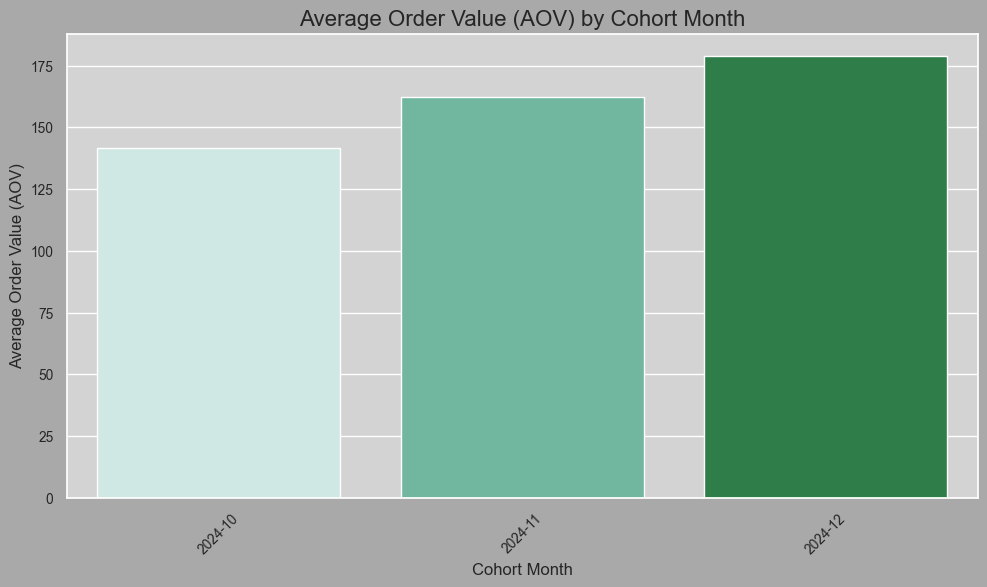

In [16]:
# plot bar graph
plt.figure(figsize=(10, 6))
sns.barplot(
    data=aov_by_cohort, 
    x='customer_cohort_month', 
    y='average_order_value', 
    palette='BuGn'
)

# format bar graph
plt.xticks(rotation=45)
plt.title('Average Order Value (AOV) by Cohort Month', fontsize=16)
plt.xlabel('Cohort Month', fontsize=12)
plt.ylabel('Average Order Value (AOV)', fontsize=12)
plt.tight_layout()

plt.show()

In [17]:
# calculate ARPU by cohort month

# convert created_at and processed_at columns to datetime
customers['created_at'] = pd.to_datetime(customers['created_at'])
orders['processed_at'] = pd.to_datetime(orders['processed_at'])

# merge orders with customers to match them with cohort months
orders_with_cohort = pd.merge(
    orders, 
    customers[['address_id', 'customer_cohort_month', 'customer_id']], 
    on='address_id', 
    how='left'
)

# group by cohort month and calculate total revenue and unique customer count
arpu_by_cohort = orders_with_cohort.groupby('customer_cohort_month').agg(
    total_revenue=('line_item_total', 'sum'),
    unique_customers=('customer_id', 'nunique')  # Unique count of customers
)

# calculate ARPU
arpu_by_cohort['average_revenue_per_user'] = (arpu_by_cohort['total_revenue'] / arpu_by_cohort['unique_customers']).round(2)

# reset index
arpu_by_cohort = arpu_by_cohort.reset_index()

# print result
arpu_by_cohort

,customer_cohort_month,total_revenue,unique_customers,average_revenue_per_user
0,2024-10,1237855.23,3567,347.03
1,2024-11,1935562.02,6654,290.89
2,2024-12,1257205.92,6483,193.92


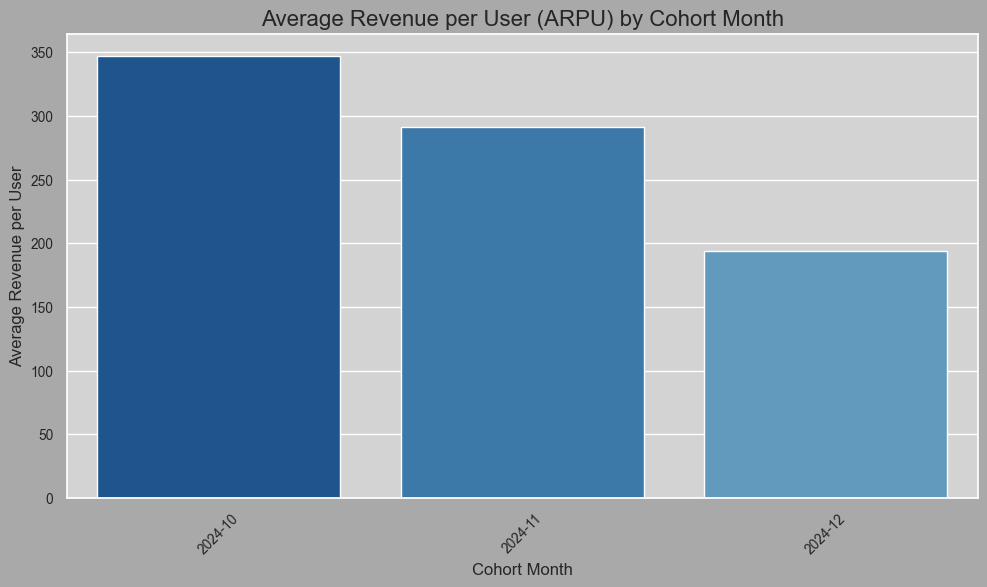

In [18]:
# plot bar graph
plt.figure(figsize=(10, 6))
sns.barplot(
    data=arpu_by_cohort, 
    x='customer_cohort_month', 
    y='average_revenue_per_user', 
    palette=sns.color_palette("Blues")[::-1]
)

# format bar graph
plt.xticks(rotation=45)
plt.title('Average Revenue per User (ARPU) by Cohort Month', fontsize=16)
plt.xlabel('Cohort Month', fontsize=12)
plt.ylabel('Average Revenue per User', fontsize=12)
plt.tight_layout()

plt.show()

In [19]:
# calculate top 5 products by revenue for each cohort month

# convert created_at and processed_at columns to datetime
subscriptions['created_at'] = pd.to_datetime(subscriptions['created_at'])
orders['processed_at'] = pd.to_datetime(orders['processed_at'])

# merge subscriptions and orders tables
product_revenue = pd.merge(
    orders[['subscription_id', 'line_item_total', 'processed_at']],
    subscriptions[['subscription_id', 'product_title']],
    on='subscription_id',
    how='left'
)

# add cohort month to the 'product_revenue'
product_revenue['cohort_month'] = product_revenue['processed_at'].dt.to_period('M')

# group by cohort month and product title, then total revenue
product_revenue_summary = product_revenue.groupby(['cohort_month', 'product_title']).agg(
    total_revenue=('line_item_total', 'sum')
).reset_index()

# sort values by revenue
top_products_by_cohort = product_revenue_summary.sort_values('total_revenue', ascending=False).head(5)

# print result
top_products_by_cohort

,cohort_month,product_title,total_revenue
93,2024-12,Liposomal Glutathione,662667.16
54,2024-11,Liposomal Glutathione,513232.98
100,2024-12,Magnesium L-Threonate,422872.12
96,2024-12,Liposomal Vitamin C,419472.47
61,2024-11,Magnesium L-Threonate,347696.00
